https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/

# Sequence to Sequence - sq2sq

## Imports

In [1]:
import os

import pandas as pd
import numpy as np

import nltk
from nltk.corpus import comtrans
from sklearn.model_selection import train_test_split

from string import punctuation
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers,models

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import datetime

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# tf.debugging.set_log_device_placement(False)

In [4]:
df =pd.read_csv(r'D:/Datasets/deu.txt',sep='\t',header=None,names=['english','german'])
df.head()

,english,german
0,Hi.,Hallo!
1,Hi.,Grüß Gott!
2,Run!,Lauf!
3,Wow!,Potzdonner!
4,Wow!,Donnerwetter!


In [5]:
df.isna().sum()

english    0
german     0
dtype: int64

In [6]:
df.shape

(153868, 2)

## Data Preprocessing

In [7]:
df.english = df.english.apply(lambda x: "".join([c for c in x if c not in punctuation]))
df.german = df.german.apply(lambda x: "".join([c for c in x if c not in punctuation]))

In [8]:
df.english = df.english.str.strip()
df.german = df.german.str.strip()

In [9]:
df.english = df.english.apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
df.german = df.german.apply(lambda x: " ".join([word for word in x.split() if len(word)>1])) 

#losing meaning by removing quotations
#deal with quotations later

In [10]:
df.english = df.english.str.lower()
df.german = df.german.str.lower()

In [11]:
num_sentences = 150000

In [12]:
df_train,df_test = train_test_split(df.sample(num_sentences,random_state=123),train_size=0.75,random_state=123)

In [13]:
df_train.head()

,english,german
98876,the baby is looking for its mother,das baby sucht seine mutter
132402,ill write to you or ill phone you next week,ich werde dir nächste woche schreiben oder dic...
141745,she wanted piece of cake but there was none left,sie wollte ein stück kuchen aber es war keiner...
15495,do owe you money,schulde ich ihnen geld
136409,the doctor administered medicine to the patient,der arzt verabreichte dem patienten medizin


In [14]:
df["eng_len"] = df.english.apply(lambda x: len([word for word in x.split()]))
df["german_len"] = df.german.apply(lambda x: len([word for word in x.split()]))

<AxesSubplot:>

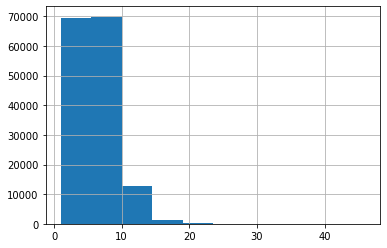

In [15]:
df.eng_len.hist()

<AxesSubplot:>

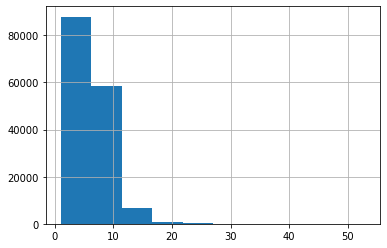

In [16]:
df.german_len.hist()

In [17]:
from nltk.corpus import stopwords

In [18]:
eng_stopwords = stopwords.words('english')
german_stopwords = stopwords.words('german')

In [19]:
# df_train.english = df_train.english.apply(lambda x: " ".join([word for word in x.split() if word not in eng_stopwords]))
# df_train.german = df_train.german.apply(lambda x: " ".join([word for word in x.split() if word not in german_stopwords]))

In [20]:
# df_test.english = df_test.english.apply(lambda x: " ".join([word for word in x.split() if word not in eng_stopwords]))
# df_test.german = df_test.german.apply(lambda x: " ".join([word for word in x.split() if word not in german_stopwords]))

In [21]:
df_train.iloc[:5,:]

,english,german
98876,the baby is looking for its mother,das baby sucht seine mutter
132402,ill write to you or ill phone you next week,ich werde dir nächste woche schreiben oder dic...
141745,she wanted piece of cake but there was none left,sie wollte ein stück kuchen aber es war keiner...
15495,do owe you money,schulde ich ihnen geld
136409,the doctor administered medicine to the patient,der arzt verabreichte dem patienten medizin


# Tokenize words

In [27]:
#length of sentences to train for
maxlen=10

#number of words in vocabulary
# num_words=9000

In [28]:
# from sklearn.model_selection import KFold

In [29]:
english_sentences_train = df_train['english']
english_sentences_test = df_test['english']

In [30]:
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(english_sentences_train)

In [31]:
eng_vocab_size = len(tokenizer.word_index)+1
eng_vocab_size

13806

In [32]:
train_sequences = tokenizer.texts_to_sequences(english_sentences_train)
test_sequences = tokenizer.texts_to_sequences(english_sentences_test)

In [33]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(train_sequences, padding='post', maxlen=maxlen)
X_test = pad_sequences(test_sequences, padding='post', maxlen=maxlen)

print(X_train[200, :]) #index corresponds to index from word-count

[   6  281 1738    0    0    0    0    0    0    0]


# Output - German words

In [34]:
# from sklearn.feature_extraction.text import CountVectorizer

In [35]:
german_tokenizer = Tokenizer(lower=True)

In [36]:
german_sentences_train = df_train["german"]
german_sentences_test = df_test["german"]

In [37]:
german_tokenizer.fit_on_texts(german_sentences_train)

In [38]:
german_text_train = german_tokenizer.texts_to_sequences(german_sentences_train)
german_text_test = german_tokenizer.texts_to_sequences(german_sentences_test)

In [39]:
# maxlen = 40 #length of sentence

y_train = pad_sequences(german_text_train, padding='post', maxlen=maxlen)
y_test = pad_sequences(german_text_test, padding='post', maxlen=maxlen)

print(y_train[0, :]) #index corresponds to index from word-count - using SparseCategoricalCrossentropy

[   7  724 1184   74  192    0    0    0    0    0]


In [40]:
y_test = np.array(y_test)
y_train = np.array(y_train)

In [41]:
german_vocab_size = len(german_tokenizer.word_counts)+1

In [42]:
german_vocab_size

27872

In [43]:
# y_train = y_train.reshape(*y_train.shape,1)
# y_test = y_test.reshape(*y_test.shape,1)

In [44]:
y_train.shape

(112500, 10)

# Neural network

In [45]:
X_train.shape

(112500, 10)

In [46]:
X_test.shape

(37500, 10)

In [47]:
#Change learning rate on palteaued training
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.9,   
    patience=1, 
    min_lr=0.0005,
    verbose=2
)

In [65]:
earlystop_callback = EarlyStopping(
  monitor='val_loss', min_delta=0.01,
  patience=3)

In [49]:
import matplotlib.pyplot as plt
def plot_loss(history,model_save_location):
    training_loss = history['loss']
    training_accuracy = history['accuracy']
    val_loss = history['val_loss']
    val_accuracy = history['val_accuracy']
    epochs = range(1,len(training_loss)+1)
    
    plt.plot(epochs,training_loss,'r-*',label='Training Loss')
#     plt.plot(epochs,training_accuracy,'r-*',label='Training Loss')
    plt.plot(epochs,val_loss,'b-o',label='Validation Loss')
#     plt.plot(epochs,val_accuracy,'r-*',label='Training Loss')
    plt.savefig(f'{model_save_location}loss.jpeg')
    plt.legend()

In [50]:
import matplotlib.pyplot as plt
def plot_accuracy(history,model_save_location):
    training_loss = history['loss']
    training_accuracy = history['accuracy']
    val_loss = history['val_loss']
    val_accuracy = history['val_accuracy']
    epochs = range(1,len(training_loss)+1)
    
#     plt.plot(epochs,training_loss,'r-*',label='Training Loss')
    plt.plot(epochs,training_accuracy,'r-*',label='Training Accuracy')
#     plt.plot(epochs,val_loss,'b-0',label='Validation Loss')
    plt.plot(epochs,val_accuracy,'b-o',label='Validation Accuracy')
    plt.savefig(f'{model_save_location}accuracy.jpeg')
    plt.legend()

# Experiments

* Target performancec metric: accuracy>=98%

### base model 2: ../data/base_model_2/

* embedding_dim = 200  #will this number capture the vocabulary in e,bedding space?
* n_lstm_units= 200 #will this number be enough to capture the complexity of language that we are trying to encode?
* batch_size= 520 #mini batch gradient descent

* Embedding layer - 10X200
* LSTM (Bidirectional) - 1X400
* repeat - 10X400
* LSTM (Bidirectional) - 10X400
* Dense - 10Xfrench_vocab_size

* early_stopping = 0.01 loss (patience =2)

* Total params: 9,840,198

* RMSprop


* Result discussion: validation plateaued while the training loss is decreasing consistently == moredata or reduce the complecity of the problem

### base model 3: ../data/base_model_3/

#changes from previous experiment - increased data by 25%

* embedding_dim = 200  
* n_lstm_units= 200
* batch_size= 520 

* Embedding layer - 10X200
* LSTM (Bidirectional) - 1X400
* repeat - 10X400
* LSTM (Bidirectional) - 10X400
* Dense - 10Xfrench_vocab_size

* early_stopping = 0.01 loss (patience =2)

* Total params: 9,840,198

* RMSprop


* Result discussion: validation plateaued while the training loss is decreasing consistently == moredata or reduce the complecity of the problem

### base model 4: ../data/base_model_4/

#changes from previous experiment - decreased data back by 25% and increased the complexity of model to get better accuracy quickly. Current 20 epoch accuracy is 55%

* embedding_dim = 200  
* n_lstm_units= 520 #cha6nged this
* batch_size= 520 

* Embedding layer - 10X200
* LSTM (Bidirectional) - 1X400
* repeat - 10X400
* LSTM (Bidirectional) - 10X400
* Dense - 10Xfrench_vocab_size

* early_stopping = 0.01 loss (patience =2)

* Total params: 9,840,198

* RMSprop


* Result discussion: validation accuracy reached 0.5 quickly compared to previous experiment BUT did not solve the overfitting problem yet

### base model 5: ../data/base_model_5/

#changes from previous experiment : increased the modelcomplexity even more 

* embedding_dim = 520  #changed this
* n_lstm_units= 200
* batch_size= 520 

* Embedding layer - 10X200
* LSTM (Bidirectional) - 1X400
* repeat - 10X400
* LSTM (Bidirectional) - 10X400
* Dense - 10Xfrench_vocab_size

* early_stopping = 0.01 loss (patience =2)

* Total params: 9,840,198

* RMSprop


* Result discussion: validation plateaued while the training loss is decreasing consistently

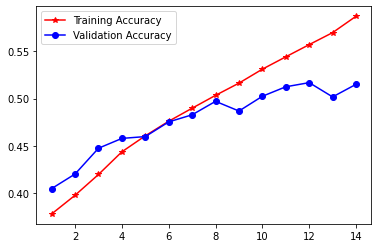

In [137]:
plot_accuracy(history.history,model_save_location)

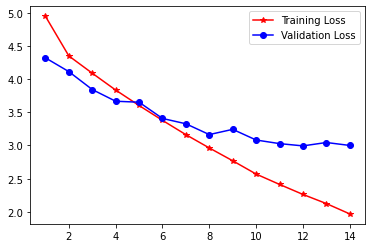

In [138]:
plot_loss(history.history,model_save_location)

### base model 6: ../data/base_model_6/

#changes from previous experiment - Increased the complexity of model

* embedding_dim = 512  #changed this
* n_lstm_units= 512
* batch_size= 320 

* Embedding layer - 10X200
* LSTM (Bidirectional) - 1X400
* repeat - 10X400
* LSTM (Bidirectional) - 10X400
* Dense - 10Xfrench_vocab_size

* early_stopping = 0.01 loss (patience =2)

* Total params: 9,840,198

* RMSprop


* Result discussion: Validation accuracy plateaued at around 50% . overfitting

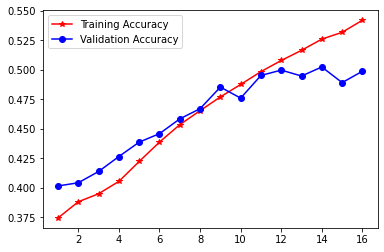

In [ ]:
plot_accuracy(history.history,model_save_location)

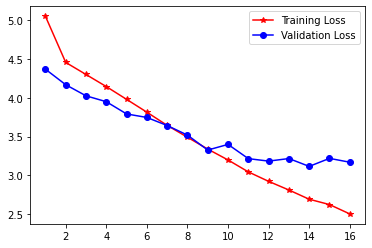

In [148]:
plot_loss(history.history,model_save_location)

Addressing overfitting problem:

* Model learnt everything it can from data and started to overfit on noise 

    * :To prevent overfitting, the best solution is to use more complete training data. The dataset should cover the full range of inputs that the model is expected to handle. Additional data may only be useful if it covers new and interesting cases."

    * A model trained on more complete data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization. These place constraints on the quantity and type of information your model can store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

### base model 7: ../data/base_model_7/

#changes from previous experiment - Addressing overfitting problem - Improved quality of data by removing stopwords threby only retaining useful information and throwing away frrquently occuring words with less value

* embedding_dim = 200
* n_lstm_units= 320
* batch_size= 320

* Embedding layer - 10X200
* LSTM (Bidirectional) - 1X400
* repeat - 10X400
* LSTM (Bidirectional) - 10X400
* Dense - 10Xfrench_vocab_size

* early_stopping = 0.01 loss (patience =2)

* Total params: 9,840,198

* RMSprop


* Result discussion: Validation accuracy plateaued at around 50% . overfitting

## Baseline model

In [66]:
model_save_location = "../models/base_model_8/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+"-"

In [67]:
from tensorflow.keras.callbacks import CSVLogger
csv_logger = CSVLogger(f'{model_save_location}history.log')

In [68]:
# Save the weights using the `checkpoint_path` format
# model.save_weights(checkpoint_path.format(epoch=0))
import datetime
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = f"{model_save_location}"+"cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
#     save_freq=5*batch_size
)

In [69]:
#maxlen (12) length of sentence
# 6000 word vocabulary in both languages
# 25k training examples and 8k test examples

embedding_dim = 400  #will this number capture the vocabulary in e,bedding space?
n_lstm_units= 320 #will this number be enough to capture the complexity of language that we are trying to encode?
batch_size= 320 #mini batch gradient descent

model = keras.Sequential()

model.add(layers.Input(shape=(maxlen,))) #input will be a 10 dimension vector [each dim is index of word]


###############  Encoder
# Input shape

# 2D tensor with shape: (batch_size, input_length).

# Output shape

# 3D tensor with shape: (batch_size, input_length, output_dim).

#input_dim : size of vocabulary
#output_dim: dimension of the dense embedding
#input_length: length of input sequences
model.add(layers.Embedding(input_dim=eng_vocab_size,  # converts sentence with 40 length to 40X200 (200 dims per word)
                           output_dim = embedding_dim,
#                            weights = [embedding_matrix],
                             input_length=maxlen,
                             name='embed_english_words',
                            mask_zero=True
)) 


#Input shape of LSTM : (batch_size, time_steps, seq_len)
# output shape of LSTM : (batch_size,num_units) if return_sequences=False
# output shape of LSTM : (batch-size, time_steps, num_units) if return_sequences=True
model.add(
#     layers.Bidirectional(
    layers.LSTM(n_lstm_units,
                return_sequences=False,
                activation="tanh"
               )
#     )
         )


###############  Decoder

model.add(layers.RepeatVector(maxlen))


model.add(
#     layers.Bidirectional(
    layers.LSTM(n_lstm_units,
                return_sequences=True,
                activation="tanh"
               )
#     )
         )

# TimeDistributed applies the same weights to each of the timestamps
#input_shape for Timedistributed: (batch_size,time_steps,dims)
#output_shape for Timedistributed: (batch_size,time_steps,output_of_wrapped_layer)

#Dense layer
# Input shape

# N-D tensor with shape: (batch_size, ..., input_dim). The most common situation would be a 2D input with shape (batch_size, input_dim).

# Output shape

# N-D tensor with shape: (batch_size, ..., units). For instance, for a 2D input with shape (batch_size, input_dim), the output would have shape (batch_size, units).

# model_3.add(layers.TimeDistributed(layers.Dense(num_words,activation='softmax'))) #probability for frnech word in each timestep
model.add(layers.Dense(german_vocab_size,activation='softmax')) #probability for frnech word in each timestep

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed_english_words (Embeddi (None, 10, 400)           5522400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 320)               922880    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 320)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 320)           820480    
_________________________________________________________________
dense_1 (Dense)              (None, 10, 27872)         8946912   
Total params: 16,212,672
Trainable params: 16,212,672
Non-trainable params: 0
_________________________________________________________________


In [71]:
rms = optimizers.Adam(learning_rate=0.001)
model.compile(loss=tf.losses.sparse_categorical_crossentropy,
                  optimizer=rms,
                  metrics=['accuracy'])

In [79]:
# Train the model with the new callback
history = model.fit(X_train, 
          y_train,
          epochs=25, 
          batch_size=batch_size, 
          callbacks=[
              cp_callback,
#                      LearningRateReducerCb(),
                     earlystop_callback,
                     reduce_lr,
              csv_logger
#                      tensorboard_callback
                    ],
          validation_data=(X_test, y_test),
          verbose=1)

Epoch 1/25
352/352 [==============================] - 66s 187ms/step - loss: 1.7683 - accuracy: 0.6194 - val_loss: 2.3930 - val_accuracy: 0.5659

Epoch 00001: saving model to ../models/base_model_8\20210824-053923-cp-0001.ckpt
Epoch 2/25
352/352 [==============================] - 67s 190ms/step - loss: 1.6928 - accuracy: 0.6291 - val_loss: 2.3734 - val_accuracy: 0.5693

Epoch 00002: saving model to ../models/base_model_8\20210824-053923-cp-0002.ckpt
Epoch 3/25
352/352 [==============================] - 87s 248ms/step - loss: 1.6209 - accuracy: 0.6396 - val_loss: 2.3604 - val_accuracy: 0.5717

Epoch 00003: saving model to ../models/base_model_8\20210824-053923-cp-0003.ckpt
Epoch 4/25
352/352 [==============================] - 121s 346ms/step - loss: 1.5554 - accuracy: 0.6498 - val_loss: 2.3517 - val_accuracy: 0.5722

Epoch 00004: saving model to ../models/base_model_8\20210824-053923-cp-0004.ckpt
Epoch 5/25
352/352 [==============================] - 137s 389ms/step - loss: 1.4960 - accu

In [80]:
model.save(f'{model_save_location}model')
#increasing batch size resulted in faster results

INFO:tensorflow:Assets written to: ../models/base_model_8/20210824-053923-model\assets


INFO:tensorflow:Assets written to: ../models/base_model_8/20210824-053923-model\assets


In [81]:
import joblib
joblib.dump(tokenizer,f'{model_save_location}english_tokenizer')

['../models/base_model_8/20210824-053923-english_tokenizer']

In [82]:
inv_map = {v: k for k, v in german_tokenizer.word_index.items()}

In [83]:
joblib.dump(inv_map,f'{model_save_location}inverse_map')

['../models/base_model_8/20210824-053923-inverse_map']

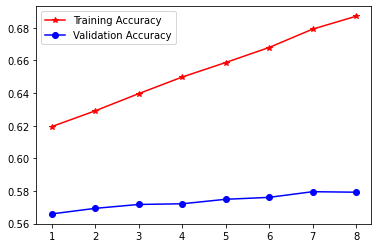

In [84]:
plot_accuracy(history.history,model_save_location)

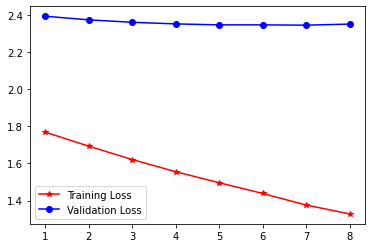

In [85]:
plot_loss(history.history,model_save_location)

In [86]:
logits = model.predict(X_test[:5])
for logit in logits:
    print(' '.join([inv_map[prediction] for prediction in np.argmax(logit, 1) if prediction!=0] ))
#     print([str(prediction) for prediction in np.argmax(logit, 1)])

tom und maria john
wer macht sonst sonst
ich begreife nicht die nicht nicht nicht nicht nicht
ich muss morgen früh früh
tom und maria sind sich jahr jahr krankenhaus


In [87]:
actual = y_test[:5]
for sen in actual:
    print(' '.join([inv_map[word] for word in sen if word!=0] ))

tom und mary adoptierten john
wer benutzt es sonst noch
ich habe herausgefunden warum die maschine nicht ging
ich muss morgen ganz zeitig aufstehen
tom und maria wollen nächstes jahr kommen


In [ ]:
english-dutch